# Plant Leaf Background Removal

This notebook implements a **Background Removal** for plant leaf disease detection with better accuracy and performance.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')


##  Improved Background Removal Class

A simplified and more robust background removal implementation.

In [3]:
class ImprovedBackgroundRemover:
    def __init__(self, image_path: str):
        self.image_path = image_path
        self.original_image = cv2.imread(image_path)
        if self.original_image is None:
            raise ValueError(f"Could not load image from {image_path}")
        # Convert to RGB for processing
        self.image = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB)
        self.height, self.width = self.image.shape[:2]
        # Store results
        self.mask = None
        self.foreground = None
        self.background = None
    
    def create_leaf_mask(self) -> np.ndarray:
        """
        Create a robust mask for leaf detection using improved color thresholding
        """
        try:
            # Convert to HSV for better color segmentation
            hsv = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)
            # Improved green color ranges for plant leaves
            # Main green range
            lower_green1 = np.array([30, 20, 20])
            upper_green1 = np.array([90, 255, 255])
            # Extended range for yellowish/diseased leaves
            lower_green2 = np.array([20, 25, 25])
            upper_green2 = np.array([35, 255, 255])
            # Create masks
            mask1 = cv2.inRange(hsv, lower_green1, upper_green1)
            mask2 = cv2.inRange(hsv, lower_green2, upper_green2)
            # Combine masks
            combined_mask = cv2.bitwise_or(mask1, mask2)
            # Apply morphological operations to clean up
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            # Remove noise
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
            # Fill holes
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
            # Find largest connected component (main leaf)
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(combined_mask)
            if num_labels > 1:
                # Find the largest component
                largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                leaf_mask = (labels == largest_label).astype(np.uint8) * 255
            else:
                leaf_mask = combined_mask
            # Additional smoothing
            leaf_mask = cv2.GaussianBlur(leaf_mask, (3, 3), 0)
            leaf_mask = (leaf_mask > 128).astype(np.uint8) * 255
            self.mask = leaf_mask
            return leaf_mask
        except Exception as e:
            print(f"Error in leaf mask creation: {e}")
            # Fallback to simple thresholding
            gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
            _, fallback_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            self.mask = fallback_mask
            return fallback_mask
    
    def apply_mask(self, mask: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply mask to extract foreground and background
        """
        if mask is None:
            if self.mask is None:
                raise ValueError("No mask available. Run create_leaf_mask() first.")
            mask = self.mask
        # Ensure mask is binary
        mask = (mask > 128).astype(np.uint8) * 255
        # Create 3-channel mask
        mask_3d = np.stack([mask] * 3, axis=2)
        # Extract foreground (leaf)
        foreground = np.where(mask_3d == 255, self.image, 0)
        # Extract background
        background = np.where(mask_3d == 0, self.image, 0)
        self.foreground = foreground
        self.background = background
        return foreground, background
    
    def show_results(self) -> None:
        """
        Display the results in a clean format
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        # Original image
        axes[0].imshow(self.image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        # Mask
        if self.mask is not None:
            axes[1].imshow(self.mask, cmap='gray')
            axes[1].set_title('Leaf Mask')
            axes[1].axis('off')
        # Foreground
        if self.foreground is not None:
            axes[2].imshow(self.foreground)
            axes[2].set_title('Background Removed')
            axes[2].axis('off')
        plt.tight_layout()
        plt.show()
    
    def calculate_metrics(self) -> dict:
        """
        Calculate quality metrics for the background removal
        """
        if self.mask is None:
            return {}
        foreground_pixels = np.sum(self.mask > 128)
        total_pixels = self.mask.size
        foreground_ratio = foreground_pixels / total_pixels
        return {
            'foreground_ratio': foreground_ratio,
            'foreground_pixels': foreground_pixels,
            'total_pixels': total_pixels,
            'image_size': (self.width, self.height)
        }

##  Test the Improved Implementation

Let's test our improved background removal with a sample image.

 Testing improved background removal with: Plant_leave_diseases_dataset_without_augmentation/Tomato___healthy/image (17).JPG
 Creating leaf mask...
 Extracting foreground...
 Displaying results...


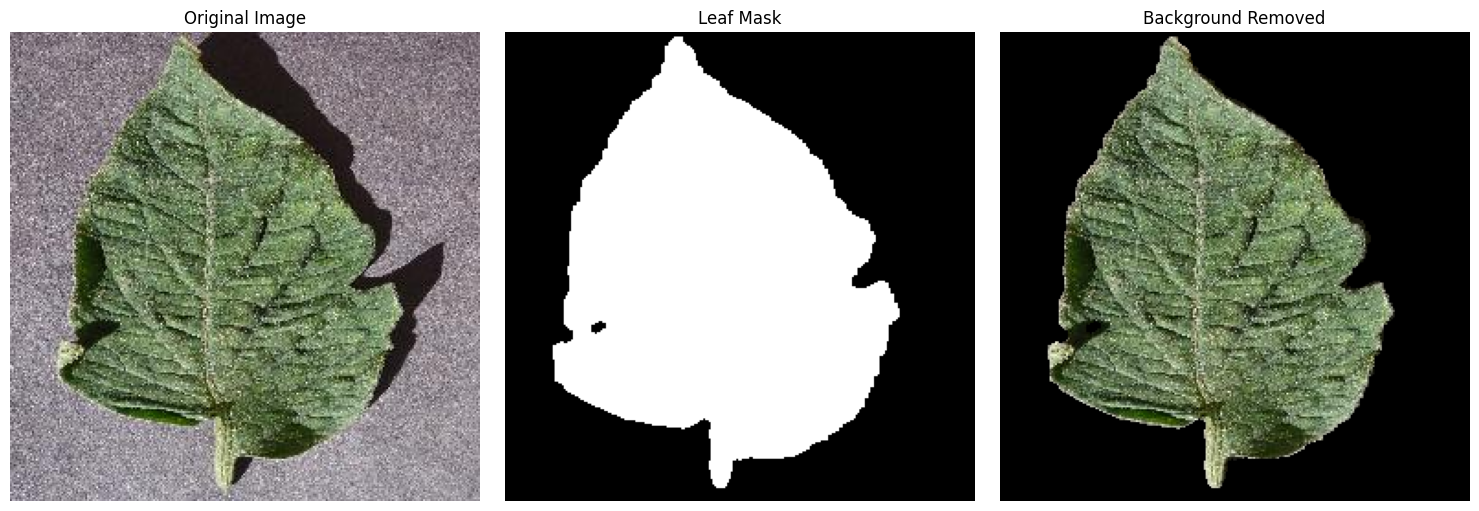

 Quality Metrics:
  foreground_ratio: 0.431
  foreground_pixels: 28269
  total_pixels: 65536
  image_size: (256, 256)
 Test completed successfully!


In [4]:
# Test with a sample image
test_image = "Plant_leave_diseases_dataset_without_augmentation/Tomato___healthy/image (17).JPG"

if os.path.exists(test_image):
    print(f" Testing improved background removal with: {test_image}")
    # Create improved background remover
    remover = ImprovedBackgroundRemover(test_image)
    # Create leaf mask
    print(" Creating leaf mask...")
    mask = remover.create_leaf_mask()
    # Extract foreground
    print(" Extracting foreground...")
    foreground, background = remover.apply_mask()
    # Display results
    print(" Displaying results...")
    remover.show_results()
    # Show metrics
    metrics = remover.calculate_metrics()
    print(" Quality Metrics:")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.3f}")
        else:
            print(f"  {key}: {value}")
    print(" Test completed successfully!")
else:
    print(f" Test image not found: {test_image}")

## 🔧 Batch Processing Function

Simplified batch processing for the entire dataset.

In [5]:
def process_single_image_simplified(image_path: str, input_dir: str, output_dir: str) -> bool:
    """
    Process a single image with improved background removal
    """
    try:
        # Create remover
        remover = ImprovedBackgroundRemover(image_path)
        # Create mask and extract foreground
        mask = remover.create_leaf_mask()
        foreground, _ = remover.apply_mask()
        # Create output path
        rel_path = os.path.relpath(image_path, input_dir)
        output_path = os.path.join(output_dir, rel_path)
        # Create output directory
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        # Save result
        foreground_bgr = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR)
        success = cv2.imwrite(output_path, foreground_bgr)
        return success
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

def process_dataset_improved(input_dir: str, output_dir: str = "background_removed_improved", max_images: int = None) -> None:
    """
    Process dataset with improved background removal
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    image_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if any(file.endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(root, file))
    # Limit number of images if specified
    if max_images is not None:
        image_files = image_files[:max_images]
    print(f" Processing {len(image_files)} images...")
    start_time = time.time()
    successful = 0
    failed = 0
    for i, image_path in enumerate(image_files):
        if process_single_image_simplified(image_path, input_dir, output_dir):
            successful += 1
        else:
            failed += 1
        # Progress update
        if (i + 1) % 50 == 0:
            elapsed = time.time() - start_time
            rate = (i + 1) / elapsed
            print(f"Progress: {i + 1}/{len(image_files)} - {rate:.1f} images/sec")
    end_time = time.time()
    total_time = end_time - start_time
    print(f" Processing complete!")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")
    print(f"Success rate: {successful/len(image_files)*100:.1f}%")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Average rate: {len(image_files)/total_time:.2f} images/second")
    print(f"Results saved to: {output_dir}")

## Run Batch Processing

Process a sample of the dataset to test the improved implementation.

In [6]:
# Process a sample for testing
input_directory = "Plant_leave_diseases_dataset_without_augmentation"
output_directory = "background_removed_improved"

if os.path.exists(input_directory):
    print(f" Starting improved batch processing...")
    print(f"Input: {input_directory}")
    print(f"Output: {output_directory}")
    # Process a small sample for testing (adjust max_images as needed)
    process_dataset_improved(input_directory, output_directory, max_images=None)
else:
    print(f" Input directory not found: {input_directory}")

 Starting improved batch processing...
Input: Plant_leave_diseases_dataset_without_augmentation
Output: background_removed_improved
 Processing 18160 images...


Progress: 50/18160 - 258.1 images/sec
Progress: 100/18160 - 300.1 images/sec
Progress: 150/18160 - 318.1 images/sec
Progress: 200/18160 - 303.3 images/sec
Progress: 250/18160 - 308.2 images/sec
Progress: 300/18160 - 304.4 images/sec
Progress: 350/18160 - 310.1 images/sec
Progress: 400/18160 - 314.8 images/sec
Progress: 450/18160 - 312.6 images/sec
Progress: 500/18160 - 316.8 images/sec
Progress: 550/18160 - 321.2 images/sec
Progress: 600/18160 - 319.5 images/sec
Progress: 650/18160 - 321.2 images/sec
Progress: 700/18160 - 320.2 images/sec
Progress: 750/18160 - 322.6 images/sec
Progress: 800/18160 - 324.5 images/sec
Progress: 850/18160 - 327.1 images/sec
Progress: 900/18160 - 326.3 images/sec
Progress: 950/18160 - 326.5 images/sec
Progress: 1000/18160 - 327.8 images/sec
Progress: 1050/18160 - 328.3 images/sec
Progress: 1100/18160 - 330.1 images/sec
Progress: 1150/18160 - 330.1 images/sec
Progress: 1200/18160 - 328.6 images/sec
Progress: 1250/18160 - 330.1 images/sec
Progress: 1300/18160

##  Results Analysis

Compare the improved results with the original implementation.

 Comparing original vs improved results...


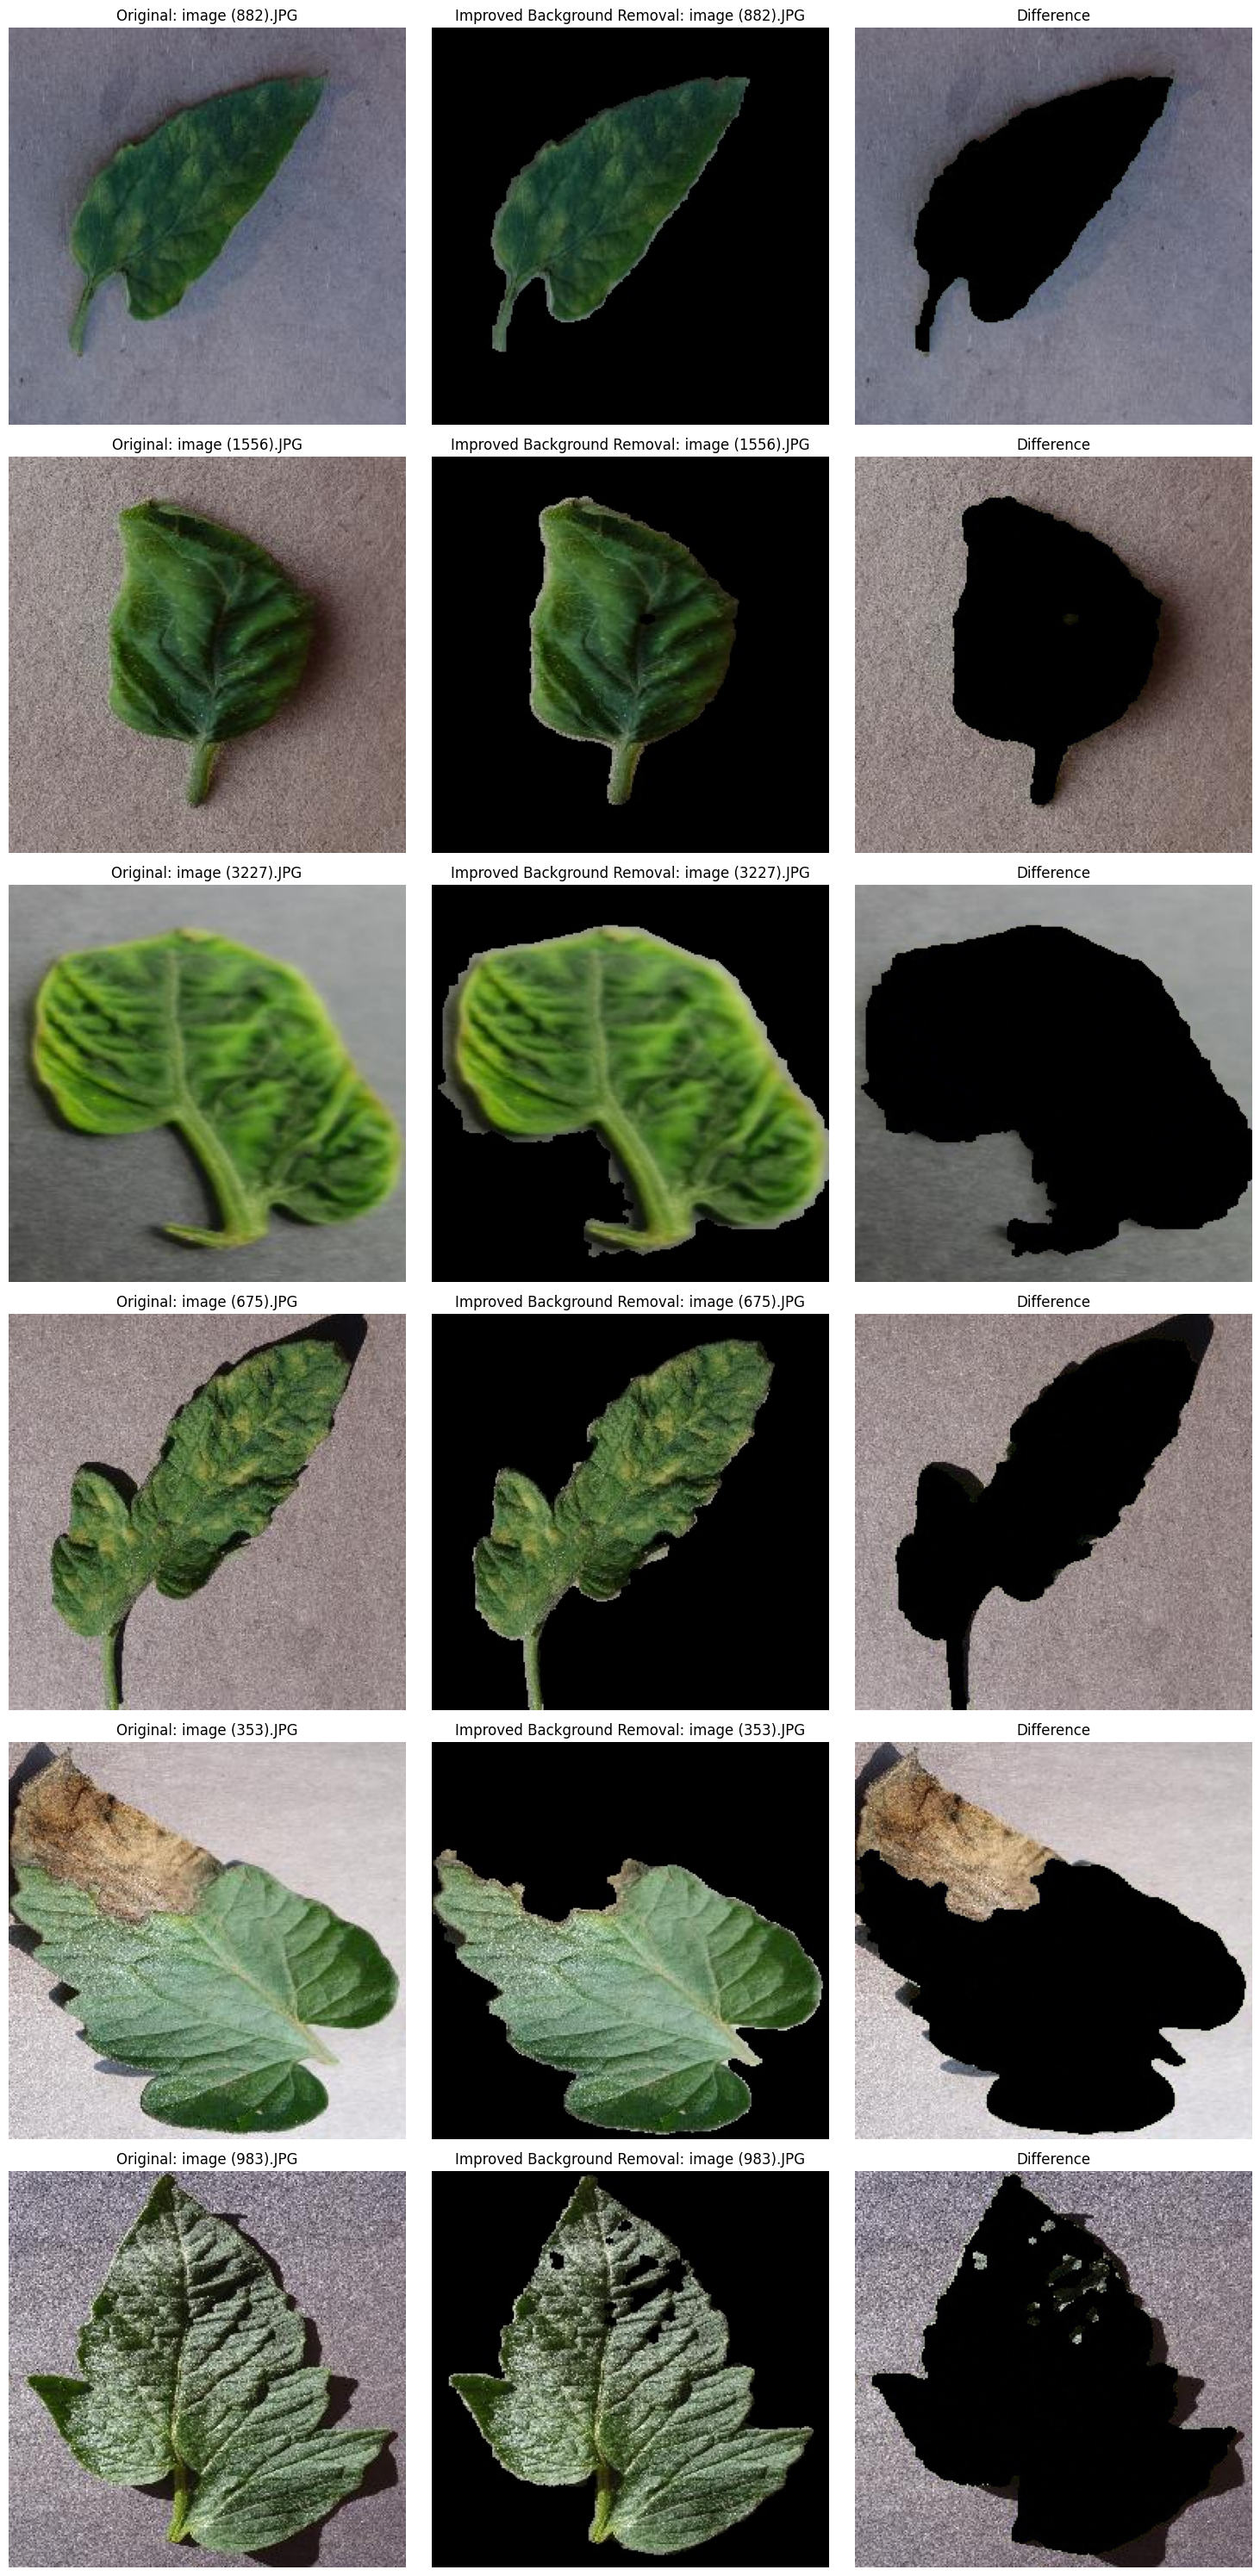

In [8]:
def compare_results(original_dir: str, improved_dir: str, sample_size: int = 6):
    """
    Compare original vs improved background removal results
    """
    import random
    # Get sample files from improved results
    improved_files = []
    for root, dirs, files in os.walk(improved_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
                improved_files.append(os.path.join(root, file))
    # Select random samples
    sample_files = random.sample(improved_files, min(sample_size, len(improved_files)))
    # Create comparison gallery
    cols = 3
    total = len(sample_files) * cols
    rows = (total + cols - 1) // cols
    fig = plt.figure(figsize=(15, rows * 5))
    for i, improved_path in enumerate(sample_files):
        # Get corresponding original path
        rel_path = os.path.relpath(improved_path, improved_dir)
        original_path = os.path.join(original_dir, rel_path)
        # Load images
        if os.path.exists(original_path):
            original = cv2.imread(original_path)
            original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
            improved = cv2.imread(improved_path)
            improved = cv2.cvtColor(improved, cv2.COLOR_BGR2RGB)
            # Original
            plt.subplot(rows, cols, 3*i + 1)
            plt.imshow(original)
            plt.title(f'Original: {os.path.basename(original_path)}')
            plt.axis('off')
            # Improved result
            plt.subplot(rows, cols, 3*i + 2)
            plt.imshow(improved)
            plt.title(f'Improved Background Removal: {os.path.basename(improved_path)}')
            plt.axis('off')
            # Show the difference (if both have same size)
            if original.shape[:2] == improved.shape[:2]:
                diff = cv2.absdiff(original, improved)
                plt.subplot(rows, cols, 3*i + 3)
                plt.imshow(diff)
                plt.title('Difference')
                plt.axis('off')
    plt.tight_layout()
    plt.show()

# Compare results
if os.path.exists(input_directory) and os.path.exists(output_directory):
    print(" Comparing original vs improved results...")
    compare_results(input_directory, output_directory, sample_size=6)
# Compare results


